# Face Detection and Emotion Recognition






## Import Libraries and Data

In [ ]:
import struct
import numpy as np
from keras.layers import Conv2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import LeakyReLU
from keras.layers import ZeroPadding2D
from keras.layers import UpSampling2D
from keras.layers.merge import add, concatenate
from keras.models import Model
from tensorflow.keras.utils import to_categorical

In [ ]:
### CNN models ###
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import TensorBoard
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D, SeparableConv2D
from keras.utils import np_utils
from keras.regularizers import l2#, activity_l2
from tensorflow.keras.optimizers import SGD, RMSprop
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import BatchNormalization
from keras import models
from keras.utils.vis_utils import plot_model
from keras.layers import Input, GlobalAveragePooling2D
from keras.models import Model
from tensorflow.keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from numpy import expand_dims, asarray
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import cv2
import numpy as np
from tensorflow.keras import backend as K

# define the expected input shape for the model
input_w, input_h = 224,224

In [ ]:
from scipy.ndimage import zoom
from skimage.feature import hog
import dlib
import scipy
import matplotlib.pyplot as plt

In [ ]:
# Unzip training data from drive

!unzip -q '/content/drive/MyDrive/FYP/val_set.zip' 
!unzip -q '/content/drive/MyDrive/FYP/trainset.zip' 
!unzip -q '/content/drive/MyDrive/FYP/train.zip'

## YoloV3 Model

In [ ]:
def _conv_block(inp, convs, skip=True):
    x = inp
    count = 0
    for conv in convs:
        if count == (len(convs) - 2) and skip:
            skip_connection = x
        count += 1
        if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
        x = Conv2D(conv['filter'],
                   conv['kernel'],
                   strides=conv['stride'],
                   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
                   name='conv_' + str(conv['layer_idx']),
                   use_bias=False if conv['bnorm'] else True)(x)
        if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
        if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
    return add([skip_connection, x]) if skip else x

In [ ]:
def make_yolov3_model():
    input_image = Input(shape=(None, None, 3))
    # Layer  0 => 4
    x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
                                  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
                                  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
                                  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
    # Layer  5 => 8
    x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
                        {'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
    # Layer  9 => 11
    x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
                        {'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
    # Layer 12 => 15
    x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
                        {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
                        {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
    # Layer 16 => 36
    for i in range(7):
        x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
                            {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
    skip_36 = x
    # Layer 37 => 40
    x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
    # Layer 41 => 61
    for i in range(7):
        x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
                            {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
    skip_61 = x
    # Layer 62 => 65
    x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
    # Layer 66 => 74
    for i in range(3):
        x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
                            {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
    # Layer 75 => 79
    x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
                        {'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
                        {'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
    # Layer 80 => 82
    yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
                              {'filter':  18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
    # Layer 83 => 86
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_61])
    # Layer 87 => 91
    x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
                        {'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
                        {'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
    # Layer 92 => 94
    yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
                              {'filter': 18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
    # Layer 95 => 98
    x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
    x = UpSampling2D(2)(x)
    x = concatenate([x, skip_36])
    # Layer 99 => 106
    yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
                               {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
                               {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
                               {'filter': 18, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
    model = Model(input_image, [yolo_82, yolo_94, yolo_106])
    return model

In [ ]:
class WeightReader:
    def __init__(self, weight_file):
        with open(weight_file, 'rb') as w_f:
            major,  = struct.unpack('i', w_f.read(4))
            minor,  = struct.unpack('i', w_f.read(4))
            revision, = struct.unpack('i', w_f.read(4))
            if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
                w_f.read(8)
            else:
                w_f.read(4)
                transpose = (major > 1000) or (minor > 1000)
            binary = w_f.read()
        self.offset = 0
        self.all_weights = np.frombuffer(binary, dtype='float32')
        
    def read_bytes(self, size):
        self.offset = self.offset + size
        return self.all_weights[self.offset-size:self.offset]
    
    def load_weights(self, model):
        for i in range(106):
            try:
                conv_layer = model.get_layer('conv_' + str(i))
                print("loading weights of convolution #" + str(i))
                if i not in [81, 93, 105]:
                    norm_layer = model.get_layer('bnorm_' + str(i))
                    size = np.prod(norm_layer.get_weights()[0].shape)
                    beta  = self.read_bytes(size) # bias
                    gamma = self.read_bytes(size) # scale
                    mean  = self.read_bytes(size) # mean
                    var   = self.read_bytes(size) # variance
                    weights = norm_layer.set_weights([gamma, beta, mean, var])
                if len(conv_layer.get_weights()) > 1:
                    bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel, bias])
                else:
                    kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
                    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
                    kernel = kernel.transpose([2,3,1,0])
                    conv_layer.set_weights([kernel])
            except ValueError:
                print("no convolution #" + str(i))
    
    def reset(self):
        self.offset = 0

In [ ]:
model = make_yolov3_model()

NameError: ignored

In [ ]:
weight_reader = WeightReader('/content/drive/MyDrive/FYP/yolov3-wider_16000.weights')
weight_reader.load_weights(model)

In [ ]:
model.save('/content/drive/MyDrive/FYP/model.h5')

## Face Localization and Bounding box Helper functions

In [ ]:
model = load_model('/content/drive/MyDrive/FYP/model.h5')

In [ ]:
import numpy as np
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle

class BoundBox:
    def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
        self.xmin = xmin
        self.ymin = ymin
        self.xmax = xmax
        self.ymax = ymax
        self.objness = objness
        self.classes = classes
        self.label = -1
        self.score = -1
        
    def get_label(self):
        if self.label == -1:
            self.label = np.argmax(self.classes)
        
        return self.label
    
    def get_score(self):
        if self.score == -1:
            self.score = self.classes[self.get_label()]
        
        return self.score


def _sigmoid(x):
    return 1. / (1. + np.exp(-x))

In [ ]:
def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2] # 0 and 1 is row and column 13*13
    nb_box = 3 # 3 anchor boxes
    netout = netout.reshape((grid_h, grid_w, nb_box, -1)) #13*13*3 ,-1
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes


def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [ ]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
            return 0
        else:
            return min(x2,x4) - x3

#intersection over union        
def bbox_iou(box1, box2):
    intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
    intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
    intersect = intersect_w * intersect_h
    
    
    w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin  
    w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
    
    #Union(A,B) = A + B - Inter(A,B)
    union = w1*h1 + w2*h2 - intersect
    return float(intersect) / union

In [ ]:
def do_nms(boxes, nms_thresh):    #boxes from correct_yolo_boxes and  decode_netout
    if len(boxes) > 0:
        nb_class = len(boxes[0].classes)
    else:
        return
    for c in range(nb_class):
        sorted_indices = np.argsort([-box.classes[c] for box in boxes])
        for i in range(len(sorted_indices)):
            index_i = sorted_indices[i]
            if boxes[index_i].classes[c] == 0: continue
            for j in range(i+1, len(sorted_indices)):
                index_j = sorted_indices[j]
                if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
                    boxes[index_j].classes[c] = 0

In [ ]:
# load and prepare an image
def load_image_pixels(filename, shape):
    # load the image to get its shape
    image = load_img(filename) #load_img() Keras function to load the image .
    width, height = image.size
    # load the image with the required size
    image = load_img(filename, target_size=shape) # target_size argument to resize the image after loading
    # convert to numpy array
    image = img_to_array(image)
    # scale pixel values to [0, 1]
    image = image.astype('float32')
    image /= 255.0  #rescale the pixel values from 0-255 to 0-1 32-bit floating point values.
    # add a dimension so that we have one sample
    image = expand_dims(image, 0)
    return image, width, height

In [ ]:
from numpy import expand_dims
from keras.models import load_model
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
import os

In [ ]:
# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
    v_boxes, v_labels, v_scores = list(), list(), list()
    # enumerate all boxes
    for box in boxes:
        # enumerate all possible labels
        for i in range(len(labels)):
            # check if the threshold for this label is high enough
            if box.classes[i] > thresh:
                v_boxes.append(box)
                v_labels.append(labels[i])
                v_scores.append(box.classes[i]*100)
    
    return v_boxes, v_labels, v_scores

In [ ]:
# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    #load the image
    img = cv2.imread(filename)
    for i in range(len(v_boxes)):
        # retrieving the coordinates from each bounding box
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        start_point = (x1, y1) 
        # Ending coordinate
        # represents the bottom right corner of rectangle 
        end_point = (x2, y2) 
        # Red color in BGR 
        color = (0, 0, 255) 
        # Line thickness of 2 px 
        thickness = 2
        # font 
        font = cv2.FONT_HERSHEY_PLAIN 
        # fontScale 
        fontScale = 1.5
        #create the shape
        img = cv2.rectangle(img, start_point, end_point, color, thickness) 
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        img = cv2.putText(img, label, (x1,y1), font,  
                   fontScale, color, thickness, cv2.LINE_AA)
    # show the plot
    output = "outputs/"+filename.rsplit("/")[1].rsplit(".")[0]+'_yolov3.jpg'
    #save the image
    cv2.imwrite(output,img)
    cv2.imshow("yolov3",img)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [ ]:
def face_crop(filename, v_boxes, v_labels, v_scores):
    img = cv2.imread(filename)
    rows, cols = img.shape[0], img.shape[1]
    shape_x=48.0
    shape_y=48.0
    faces=[]
    for i in range(len(v_boxes)):
        if (not v_boxes):
            x1,y1 = 0,0
            x2,y2 = 0,0
        else:
            box = v_boxes[i]
            y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
            cropped_image = img[y1:y2, x1:x2]
            if cropped_image.shape[0]==0 or cropped_image.shape[1]==0:
              print(cropped_image.shape,v_boxes[i],filename)
              continue
            new_extracted_face = zoom(cropped_image, (shape_x / cropped_image.shape[0],shape_y / cropped_image.shape[1],1),order=3, mode='wrap')
            #cast type float
            new_extracted_face = new_extracted_face.astype(np.float32)
            #scale
            new_extracted_face /= float(new_extracted_face.max())
            faces.append(new_extracted_face)
    return faces


## Test YoloV3

In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]  

# define the probability threshold for detected objects
class_threshold = 0.6

labels = ["face"]


In [ ]:
def get_label(argument):
    labels = {0:'Neutral', 1:'Happy', 2:'Sad', 3:'Surprise', 4:'Fear' , 5:'Disgust', 6:'Anger', 7:'Contempt'}
    return(labels.get(argument, "Invalid emotion"))

In [ ]:
from google.colab.patches import cv2_imshow
def find_face(photo_filename):
  boxes = list()
  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
  yhat = model.predict(image)
  for i in range(len(yhat)):
      # decode the output of the network
      boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
      
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)  #Discard all boxes with pc less or equal to 0.5

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  faces = face_crop(photo_filename, v_boxes, v_labels, v_scores)
  return faces

## Feature Extraction

In [ ]:
shape_x = 48
shape_y = 48
window_size = 24
window_step = 6

In [ ]:
def sliding_hog_windows(image):
    hog_windows = []
    for y in range(0, shape_x, window_step):
        for x in range(0, shape_y, window_step):
            window = image[y:y+window_size, x:x+window_size]
            hog_windows.extend(hog(window, orientations=8, pixels_per_cell=(8, 8),
                                            cells_per_block=(1, 1), visualize=False))
    return hog_windows

## Import Dataset and apply

In [ ]:
input_w, input_h = 224, 224
directory = '/content/val_set/images/'
# dir2 = '/content/trainset/images/'
annotations = '/content/val_set/annotations/'
# annot2 = '/content/trainset/annotations/'
suffix = '_exp.npy'
imgs = []
target= []
val_imgs = []
val_target = []
val_hog_slide_images = []
val_hog_slide_features = []
hog_slide_images = []
hog_slide_features = []

direct = '/content/train/'
for dir in os.listdir(direct):
  for filename in os.listdir(direct+dir):
    photo_filename = direct+dir+"/"+filename
    exp = int(dir)
    img = cv2.imread(photo_filename)
    img = zoom(img, (48 / img.shape[0],48 / img.shape[1],1),order=3, mode='wrap')
    face = asarray(img)
    face_1 = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
    image1 = face_1.reshape((shape_x, shape_y,1))
    features = sliding_hog_windows(image1)
    f, hog_image = hog(image1, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
    hog_slide_features.append(features)
    hog_slide_images.append(hog_image)
    imgs.append(image1)
    target.append(exp)
for filename in os.listdir(directory):
  photo_filename = directory+filename
  name = filename.split('.')[0]
  with open(annotations+name+suffix,'rb') as f:
    exp = np.load(f)
  img = cv2.imread(photo_filename)
  img = zoom(img, (48 / img.shape[0],48 / img.shape[1],1),order=3, mode='wrap')
  face = asarray(img)
  face_1 = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
  image1 = face_1.reshape((shape_x, shape_y,1))
  features = sliding_hog_windows(image1)
  f, hog_image = hog(image1, orientations=8, pixels_per_cell=(16, 16),cells_per_block=(1, 1), visualize=True)
  val_hog_slide_features.append(features)
  val_hog_slide_images.append(hog_image)
  val_imgs.append(image1)
  val_target.append(exp)

In [ ]:
X = np.array(imgs)
X = np.vstack(X)
y = np.array(target)
X = np.reshape(X, (len(imgs),48,48,1))
y = np.reshape(y, (y.shape[0],1))
train_data = X.astype('float32')
train_data /= 255
train_labels_one_hot = to_categorical(y)

In [ ]:
X_val = np.array(val_imgs)
X_val = np.vstack(X_val)
y_val = np.array(val_target)
X_val = np.reshape(X_val, (len(val_imgs),48,48,1))
y_val = np.reshape(y_val, (y_val.shape[0],1))
val_data = X_val.astype('float32')
val_data /= 255
val_labels_one_hot = to_categorical(y_val)

Text(0.5, 1.0, 'Ground Truth : Fear')

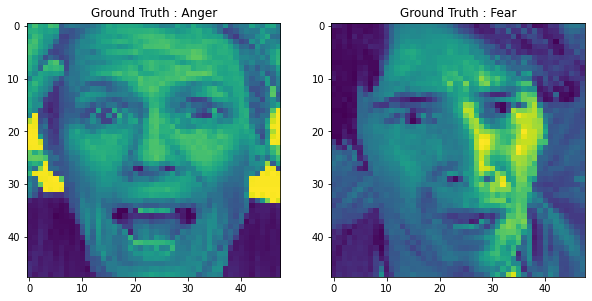

In [ ]:
plt.figure(figsize=[10,5])

# Display the first image in training data
plt.subplot(121)
plt.imshow(np.reshape(X[50],(48,48)))
plt.title("Ground Truth : {}".format(get_label(int(y[50]))))

# Display the first image in testing data
plt.subplot(122)
plt.imshow(np.reshape(X[6732],(48,48)))
plt.title("Ground Truth : {}".format(get_label(int(y[6732]))))

## Data Preparation

In [ ]:
OUTPUT_FOLDER_NAME='/content/drive/MyDrive/FYP/outputs/'
np.save(OUTPUT_FOLDER_NAME + 'train_labels_one_hot.npy', train_labels_one_hot)
np.save(OUTPUT_FOLDER_NAME + 'train_labels.npy', y)
np.save(OUTPUT_FOLDER_NAME + 'val_labels_one_hot.npy', val_labels_one_hot)
np.save(OUTPUT_FOLDER_NAME + 'val_labels.npy', y_val)

np.save(OUTPUT_FOLDER_NAME + 'train_hog_slide_images.npy', np.array(hog_slide_images))
np.save(OUTPUT_FOLDER_NAME + 'train_hog_slide_features.npy', np.array(hog_slide_features))
np.save(OUTPUT_FOLDER_NAME + 'val_hog_slide_images.npy', np.array(val_hog_slide_images))
np.save(OUTPUT_FOLDER_NAME + 'val_hog_slide_features.npy', np.array(val_hog_slide_features))

np.save(OUTPUT_FOLDER_NAME + 'train_images.npy', X)
np.save(OUTPUT_FOLDER_NAME + 'val_images.npy', X_val)

In [ ]:
X_hog_slid_img = np.load(OUTPUT_FOLDER_NAME + "train_hog_slide_images.npy").reshape(-1, 48, 48, 1)
X_imgs = np.load(OUTPUT_FOLDER_NAME + "train_images.npy")
X_new = np.concatenate((X_imgs,X_hog_slid_img),axis = 1)

In [ ]:
X_hog_slid_img_val = np.load(OUTPUT_FOLDER_NAME + "val_hog_slide_images.npy").reshape(-1, 48, 48, 1)
X_imgs_val = np.load(OUTPUT_FOLDER_NAME + "val_images.npy")
X_new_val = np.concatenate((X_imgs_val,X_hog_slid_img_val),axis = 1)

In [ ]:
np.save(OUTPUT_FOLDER_NAME + 'train_image_features.npy', X_new)
np.save(OUTPUT_FOLDER_NAME + 'val_image_features.npy', X_new_val)